In [1]:
import gym
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from collections import deque,defaultdict
import itertools
%matplotlib inline

In [2]:
env = gym.make('MountainCar-v0')
env.reset()
num_actions = env.action_space.n
print('Number of actions: ', num_actions)
state_low = env.observation_space.low
state_high = env.observation_space.high
print('State space:', [state_low, state_high])

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of actions:  3
State space: [array([-1.20000005, -0.07      ], dtype=float32), array([ 0.60000002,  0.07      ], dtype=float32)]


In [3]:
#Parameter initialization
epsilon = 0.5
γ= 0.95
α = 0.1
done_penalty = -10.0 #For CartPole

smoothing_value = 0.1
#max_steps = 10000
max_len_hist = 20000
number_of_neighbours = max_len_hist
state_hist = dict([[i,deque(maxlen=max_len_hist)] for i in range(env.action_space.n)])
srs_hist = dict([[i,deque(maxlen=max_len_hist)] for i in range(env.action_space.n)])

#Start of learning loop

In [4]:
s_ini = env.reset()
returns_episode = []
returns_episode_i = 0.0
episode_len = 0
for steps in range(max_len_hist):
    episode_len += 1
    #Taking a step in the environment
    #action = np.random.choice([np.random.choice(env.action_space.n),np.argmax(Q_sa[tuple(s_ini)])], p=[epsilon,1-epsilon])
    action = np.random.choice(env.action_space.n)
    s_next, reward, done ,_ = env.step(action)  
    #Computing return and updating memory
    #returns_episode_i += reward 
    if not done:
        srs_hist[action].append([s_ini,reward,s_next]) 
        state_hist[action].append(s_ini)
        s_ini = s_next
    else:
        srs_hist[action].append([s_ini,reward,s_next]) 
        state_hist[action].append(s_ini)
        #if episode_len < 199: #Gym Specific, since 200 is forced termination
        #    srs_hist[action].append([s_next,done_penalty,'done']) 
        #    state_hist[action].append(s_next)
        srs_hist[action].append([s_next,done_penalty,'done']) 
        state_hist[action].append(s_next)
        s_ini = env.reset()
        episode_len = 0

In [5]:
ks_a=dict([[i,deque(maxlen=max_len_hist)] for i in range(env.action_space.n)])
indices = [0] + list(np.cumsum([len(state_hist[i]) for i in range(env.action_space.n)]))[:-1]
all_states = list(itertools.chain(*[list(state_hist[i]) for i in range(env.action_space.n)]))
all_srs = list(itertools.chain(*[list(srs_hist[i]) for i in range(env.action_space.n)]))
P = [np.zeros((len(all_states),len(all_states))) for _ in range(env.action_space.n)]
R = [np.zeros(len(all_states)) for _ in range(env.action_space.n)]
for a in range(env.action_space.n):
    neigh = NearestNeighbors(n_neighbors=min(number_of_neighbours, len(state_hist[a])))
    ks_a[a] = neigh.fit([i.tolist() for i in state_hist[a]]) 
    for i in range(len(all_states)):
        sprime = all_srs[i][2]
        if sprime != 'done':
            info = ks_a[a].kneighbors(sprime.reshape(1,-1))
            weights = 1.0/(info[0][0]+smoothing_value)
            weights /= weights.sum()
            index_i = [j+indices[a] for j in info[1][0]]
            P[a][i][index_i]= weights
            R[a][i] = np.sum(P[a][i][index_i]*np.array([k[1] for k in np.array(all_srs)[index_i]]))
        else:
            P[a][i][i] = 1.0

/home/sre/gandharv/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sys.path[0] == '':


In [6]:
def VI(P_all, R_all, gamma, tau = 1e-10):
    V = np.zeros(P_all.shape[1])
    for i in range(1000):
        V_old = np.copy(V)
        Q = R_all + gamma*np.dot(P_all, V).reshape(R_all.shape, order='F')
        V = np.max(Q, axis=1)
        policy = np.argmax(R_all + gamma*np.dot(P_all, V).reshape(R_all.shape, order='F'), axis=1)
        error = np.linalg.norm(V-V_old, 2)
        if error < tau:
            print('Converged after {:} iterations with error {:}'.format(i+1, error))
            break
    #print('Optimal Values:',V)
    #print('Optimal Policy:',policy)
    return Q

In [7]:
Q = VI(np.concatenate(P, axis=0), np.array(R).T, γ)

Converged after 499 iterations with error 9.544996434370427e-11


In [9]:
γ= 0.95
number_of_neighbours = 100
smoothing_value = 0.0
max_steps = 10000

#Start of learning loop
s_ini = env.reset()
returns_episode = []
returns_episode_i = 0.0

for steps in range(max_steps): 
    #Taking a step in the environment
    q = np.zeros(env.action_space.n)
    for a in range(env.action_space.n):
        #compute weights
        info = ks_a[a].kneighbors(s_ini.reshape(1,-1))[:number_of_neighbours]
        weights = 1.0/(info[0][0]+smoothing_value)
        weights /= weights.sum()
        #compute q_targets for each neighbour
        q_target = 0.0
        for i in range(len(weights)):
            nbr = info[1][0][i]
            r = srs_hist[a][nbr][1]
            sprime = srs_hist[a][nbr][2]
            if sprime != 'done':
                q_target += weights[i]*(r+γ*Q[nbr+indices[a]].max())
            else:
                q_target += weights[i]*(r)
        #compute bellman update and assign it to q
        q[a] = q_target
    action = np.argmax(q)
    s_next, reward, done ,_ = env.step(action)
    
    #Computing return
    returns_episode_i += reward
    if not done:
        s_ini = s_next
    else:
        s_ini = env.reset()
        returns_episode.append(returns_episode_i)
        returns_episode_i = 0.0

/home/sre/gandharv/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Text(0,0.5,'Return')

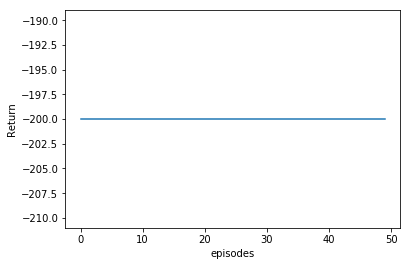

In [11]:
plt.plot(returns_episode)
plt.xlabel('episodes')
plt.ylabel('Return')


## Discussion:

Here we implement the KBRL algorithm for the mountain car environment in open-ai gym. As it can be seen from the results, the algorithm as mentioned by Ormoneit and Sen, 2002 doesnt seem to work for this environment. The main reason for this is that the reward signal in this environmemnt is very sparse and the inital model learning is heavily dependent on the portions of the state space the agent visits. As a result the agent fails to learn the model of the environment. To solve this problem using KBRL one can use some domain information like knowing the final state of the environment and letting the agent act in the environment till it reaches the final state. Further we can only retain the the transitions where the agent reached the goal state and try to learn the model using this data and/or use reward shaping.